## Clause Emissions Categorization

Putting each of the TCLP clauses into risk categories using an LLM 

In [1]:
import pandas as pd
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
import utils
import json

In [3]:
clause_folder = "../data/cleaned_content"
clause_html = '../data/clause_boxes'
model_path = "../models/CC_BERT/CC_model_detect"

In [5]:
tokenizer, d_model, c_model, names, docs, final_df, _, _ = utils.getting_started(model_path, clause_folder, clause_html)

/Users/georgia/Documents/coding/climate_risk_id/tclp/utils.py:558: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content, "html.parser")


In [6]:
df = pd.DataFrame({'name': names, 'clause': docs})

In [2]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"), 
    base_url = "https://openrouter.ai/api/v1"
)

In [56]:
def get_nonrisk_message(clause_text):     
    system_message = """The most important thing you do is follow proper JSON formatting.
    
    You are a legal expert in environmental compliance who understands 
    different type of emissions within given sectors and activities. Your task is to 
    analyze legal contract clauses and identify the different types of emissions they 
    identify help reduce. If the clause does not relate to emissions, you can frame your 
    task in terms of identifying areas to incorporate climate resilience.
    
    Ensure you are focusing on climate rather than environmental impacts more broadly.
    
    You should be more specific than just saying Scope 1, 2, or 3 emissions. 
    In fact, don't mention scopes at all in the title. Similarly 
    broad categorizations like greenhouse gas emissions or carbon emissions are not 
    sufficiently specific.
    
    Still, try to choose emissions types that can be categorized. You might imagine
    there is more than one clause that could relate to that type of emissions. 
    """

    user_message = f"""
    ### CLAUSE TO ANALYZE
    {clause_text}

    ### INSTRUCTIONS
    You are categorizing this clause according to the most relevant emissions it aims 
    to reduce. Don't be afraid to be specific and technical in your categorizations but 
    keep the names of them very succinct (no more than three words). 
    
    You can provide more context in the justification.
    
    Focus on real-world impacts that would result from the delivery of a product, 
    service, or operational activity described in the clause. Clearly name each 
    source and explain how the clause helps mitigate or reduce it. 
    
    Give between two and seven sources of emissions each time. 
    
    Return your answer in this JSON format:
    {{
        "labels": ["Climate Resilience Source 1", "Climate Resilience Source 2", ...],
        "justification": [
            "Justification for Source 1",
            "Justification for Source 2",
            ...
        ]
    }}
"""
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    return messages

In [57]:
clause_1 = df.iloc[4]['name'] + df.iloc[4]['clause'] 

In [58]:
message = get_nonrisk_message(clause_1)

In [59]:
response = client.chat.completions.create(
        model='openai/gpt-4o-mini',
        messages= message,
        temperature=0
    )

In [60]:
response.choices[0].message.content

'{\n    "labels": ["Fugitive Emissions", "Process Emissions", "Transportation Emissions", "Energy Use Emissions"],\n    "justification": [\n        "Fugitive emissions may arise from leaks in equipment or systems during the construction or operation phases. The benchmarking mechanism encourages contractors to minimize these emissions by comparing their performance against competitors, thus incentivizing better practices.",\n        "Process emissions are generated from chemical reactions in manufacturing or construction processes. By setting a Green Target and incentivizing contractors to meet or exceed it, the clause promotes the adoption of cleaner technologies and practices that can reduce these emissions.",\n        "Transportation emissions occur from the movement of materials and personnel to and from the project site. The clause encourages contractors to consider their supply chain and logistics, potentially leading to more efficient transportation methods that lower emissions."

In [53]:
def perform_emissions_analysis(clause_text):
    message = get_nonrisk_message(clause_text)
    
    response = client.chat.completions.create(
        model='openai/gpt-4o-mini',
        messages=message,
        temperature=0
    )
    
    return response.choices[0].message.content

In [54]:
long_results = []

In [61]:
for i, row in df.iterrows():
    clause_text = row['name'] + row['clause']
    print(f"Processing clause {i+1}/{len(df)}: {row['name']}")
    
    max_retries = 3
    retry_count = 0
    success = False
    
    while retry_count < max_retries and not success:
        try:
            result = perform_emissions_analysis(clause_text)
            
            # Debug: print the raw result to see what we're getting
            print(f"Raw result: {result}")
            print(f"Result type: {type(result)}")
            
            parsed = json.loads(result) if isinstance(result, str) else result
            labels = parsed.get("labels", [])
            justifications = parsed.get("justification", [])

            # Ensure list types
            if isinstance(justifications, str):
                justifications = [justifications]
            if len(justifications) != len(labels):
                # Fallback: repeat full justification for each label
                justifications = [justifications[0]] * len(labels)

            for label, justification in zip(labels, justifications):
                long_results.append({
                    "name": row['name'],
                    "risk_label": label,
                    "justification": justification
                })
            success = True
            
        except json.JSONDecodeError as e:
            retry_count += 1
            print(f"JSON decode error for clause {i+1} (attempt {retry_count}): {e}")
            print(f"Problematic result: {result}")
            
            if retry_count < max_retries:
                print(f"Retrying clause {i+1}...")
            else:
                print(f"Failed to parse clause {i+1} after {max_retries} attempts. Skipping.")
                break

results_df = pd.DataFrame(long_results)


Processing clause 1/122: A Beginner’s Guide and Checklist for Accessing Sustainability-Linked Loans (SLLs)
Raw result: {
    "labels": ["CO2 Emissions", "Water Consumption", "Energy Efficiency", "Renewable Energy"],
    "justification": [
        "The clause explicitly mentions a reduction of CO2 emissions by 4.20%, which directly addresses the mitigation of carbon dioxide emissions associated with the borrower's operations.",
        "Water consumption is highlighted with a reduction of 0.32%, indicating efforts to minimize water usage, which is crucial for sustainability and climate resilience.",
        "Improvements in energy efficiency are implied through the encouragement of ambitious sustainability performance targets (SPTs), which can lead to reduced energy consumption and associated emissions.",
        "The clause supports the transition to renewable energy sources, as it encourages borrowers to set targets that may include increases in renewable energy usage, thereby reducin

In [62]:
results_df.to_csv('../data/emissions_categorization_2.csv', index=False)

____

# Clustering Emissions

Note to self: if we go back to use these clusters, I will want to redo them in a better way but since they are being hidden away for now, this is fine. 

In [77]:
df = pd.read_csv('../data/emissions_categorization_2.csv')

In [78]:
unique_labels = df.risk_label.unique()

In [79]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(unique_labels, show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [80]:
from umap.umap_ import UMAP
umap_model = UMAP(n_components=3, min_dist=0.0, metric='euclidean', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [81]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [82]:
from bertopic import BERTopic
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(unique_labels, embeddings)

In [83]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31,-1_quality_air_emissions_drought,"[quality, air, emissions, drought, land, net, ...","[Land Use Change Emissions, Air Quality Deteri..."
1,0,50,0_waste_production_emissions_construction,"[waste, production, emissions, construction, c...","[Waste Emissions, Construction Waste, Construc..."
2,1,47,1_carbon_gas_fuel_emissions,"[carbon, gas, fuel, emissions, fossil, methane...","[Carbon Offsetting, Carbon Dioxide, Carbon Dio..."
3,2,23,2_energy_electricity_heat_consumption,"[energy, electricity, heat, consumption, effic...","[Energy Consumption, Energy Consumption Emissi..."
4,3,17,3_travel_employee_commuting_transport,"[travel, employee, commuting, transport, busin...","[Employee Commuting, Employee Commuting Emissi..."
5,4,16,4_risks_climate_risk_physical,"[risks, climate, risk, physical, liability, ad...","[Physical Risks, Climate Risk, Physical Climat..."
6,5,13,5_water_wastewater_usage_treatment,"[water, wastewater, usage, treatment, use, emi...","[Water Use Emissions, Water Treatment Emission..."
7,6,12,6_soil_loss_biodiversity_degradation,"[soil, loss, biodiversity, degradation, coral,...","[Soil Degradation Emissions, Soil Biodiversity..."
8,7,8,7_sustainable_financing_green_sustainability,"[sustainable, financing, green, sustainability...","[Paris Aligned Financing, Sustainable Financin..."
9,8,7,8_runoff_pollution_water_sedimentation,"[runoff, pollution, water, sedimentation, pest...","[Fertilizer Runoff, Water Runoff Pollution, Wa..."


In [84]:
topic_df = topic_model.get_topic_info()

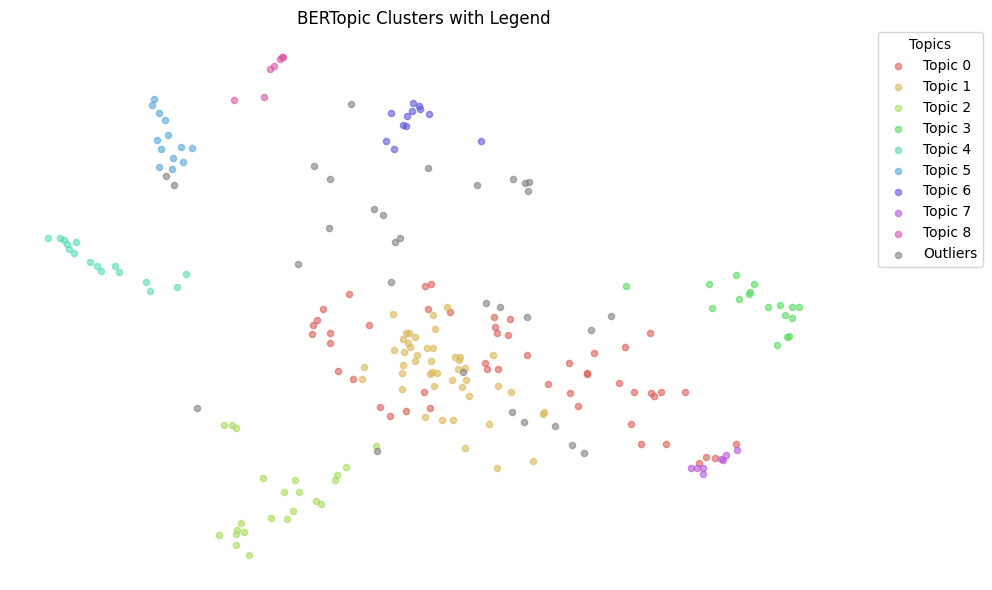

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame
df_plot = pd.DataFrame(reduced_embeddings, columns=["x", "y", "z"])
df_plot["topic"] = topics

# Create color palette (excluding -1 if present)
unique_topics = sorted(set(topics))
if -1 in unique_topics:
    unique_topics.remove(-1)
    include_outliers = True
else:
    include_outliers = False

# Assign a color per topic
palette = sns.color_palette("hls", len(unique_topics))
topic_to_color = {topic: palette[i] for i, topic in enumerate(unique_topics)}
if include_outliers:
    topic_to_color[-1] = (0.5, 0.5, 0.5)  # grey for outliers

# Assign colors to each point
df_plot["color"] = df_plot["topic"].map(topic_to_color)

# Plot
plt.figure(figsize=(10, 6))
for topic in topic_to_color:
    subset = df_plot[df_plot["topic"] == topic]
    label = f"Topic {topic}" if topic != -1 else "Outliers"
    plt.scatter(subset["x"], subset["y"], 
                c=[topic_to_color[topic]], 
                label=label, 
                s=20, alpha=0.6)

plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axis("off")
plt.title("BERTopic Clusters with Legend")
plt.tight_layout()
plt.show()


In [86]:
df_bert = pd.DataFrame({
    "text": unique_labels,
    "topic": topics,
    "probability": probs
})


In [87]:
#rename text to risk_label in df_bert
df_bert.rename(columns={"text": "risk_label"}, inplace=True)

In [88]:
#merge this back with the original results
df = df.merge(df_bert, on="risk_label", how="left", suffixes=("", "_bert"))

In [89]:
df

,name,risk_label,justification,topic,probability
0,A Beginner’s Guide and Checklist for Accessing...,CO2 Emissions,The clause explicitly mentions CO2 emissions r...,1,1.000000
1,A Beginner’s Guide and Checklist for Accessing...,Water Consumption,Water consumption is highlighted with a target...,5,0.757802
2,A Beginner’s Guide and Checklist for Accessing...,Energy Efficiency,The clause encourages improvements in energy e...,2,1.000000
3,A Beginner’s Guide and Checklist for Accessing...,Renewable Energy,"By promoting the use of renewable energy, the ...",2,1.000000
4,"Allocating Scope 1, 2 and 3 Emissions for Leas...",Fossil Fuel Combustion,The clause requires the Lessor to measure ener...,1,0.975114
...,...,...,...,...,...
530,The ‘Green Supplier’ Contract – A Standardised...,Single-Use Plastics,"By addressing single-use plastic usage, the cl...",0,0.864710
531,"Transparent Sourcing of Greener, Fairer Renewa...",Operational Emissions,The clause emphasizes minimizing operational e...,-1,0.000000
532,"Transparent Sourcing of Greener, Fairer Renewa...",Construction Emissions,By requiring the design of energy equipment to...,0,1.000000
533,"Transparent Sourcing of Greener, Fairer Renewa...",Installation Emissions,The clause targets emissions produced during t...,0,0.860840


In [90]:
df.rename(columns={"risk_label": "emission_label"}, inplace=True)


In [91]:
# Create a dictionary mapping topic numbers to concise descriptive category names
topic_category_map = {
    -1: "Outliers / Misc",
     0: "Waste and Construction Emissions",
     1: "Carbon and Fuel Emissions",
     2: "Energy and Heat Consumption",
     3: "Travel and Commuting",
     4: "Physical Climate Risks",
     5: "Water and Wastewater",
     6: "Soil and Biodiversity",
     7: "Sustainable Financing",
     8: "Runoff and Pollution"
}
df["topic_name"] = df["topic"].map(topic_category_map)



In [95]:
df.to_csv("../data/full_emissions_table_2.csv", index=False)

